<b> Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf

<b> Loading the Bombay Stock Exchange (Sensex) data for the last 4 years

In [3]:
df = yf.download('^NSEI', start="2022-06-11", end="2023-06-11")
df.tail(15)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-05-22,18201.099609,18335.250000,18178.849609,18314.400391,18314.400391,262600
2023-05-23,18362.900391,18419.750000,18324.199219,18348.000000,18348.000000,270400
2023-05-24,18294.800781,18392.599609,18262.949219,18285.400391,18285.400391,232600
2023-05-25,18268.900391,18338.099609,18202.400391,18321.150391,18321.150391,235900
2023-05-26,18368.349609,18508.550781,18333.150391,18499.349609,18499.349609,198700
2023-05-29,18619.150391,18641.199219,18581.250000,18598.650391,18598.650391,265300
2023-05-30,18606.650391,18662.449219,18575.500000,18633.849609,18633.849609,234400
2023-05-31,18594.199219,18603.900391,18483.849609,18534.400391,18534.400391,696500
2023-06-01,18579.400391,18580.300781,18464.550781,18487.750000,18487.750000,265600


<b> Checking the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 247 entries, 2022-06-13 to 2023-06-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       247 non-null    float64
 1   High       247 non-null    float64
 2   Low        247 non-null    float64
 3   Close      247 non-null    float64
 4   Adj Close  247 non-null    float64
 5   Volume     247 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.5 KB


<b> Plotting the Historical Price

Text(0.5, 0.98, 'Historical Price')

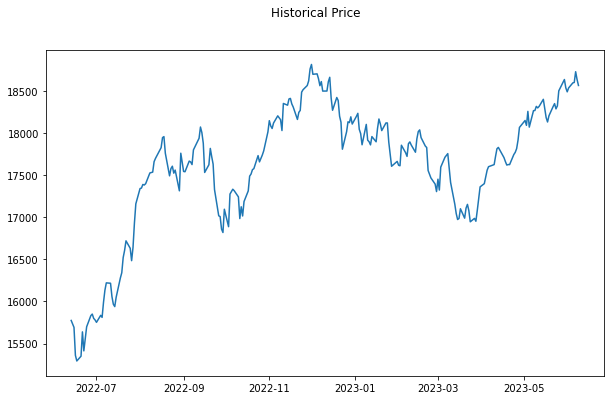

In [5]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(df['Adj Close'])
fig.suptitle('Historical Price')

<b> Defining the MACD function

In [6]:
def MACD(df, n_fast, n_slow):
    """
    Calculate the Moving Average Convergence Divergence (MACD)
    """
    EMAfast = df['Adj Close'].ewm(span=n_fast, min_periods=n_fast - 1).mean()
    EMAslow = df['Adj Close'].ewm(span=n_slow, min_periods=n_slow - 1).mean()
    macd_values = EMAfast - EMAslow
    signal = macd_values.ewm(span=9, min_periods=8).mean()
    hist = macd_values - signal
    return macd_values, signal, hist

<b> Defining a duplicate of the MACD function just adding plots to it

In [7]:
def MACD_plot(df, n_fast, n_slow):
    """
    Calculate the Moving Average Convergence Divergence (MACD)
    """
    df['EMAfast'] = df['Adj Close'].ewm(span=n_fast, min_periods=n_fast - 1).mean()
    df['EMAslow'] = df['Adj Close'].ewm(span=n_slow, min_periods=n_slow - 1).mean()
    
    EMAfast = df['Adj Close'].ewm(span=n_fast, min_periods=n_fast - 1).mean()
    EMAslow = df['Adj Close'].ewm(span=n_slow, min_periods=n_slow - 1).mean() 
    macd_values = EMAfast - EMAslow
    signal = macd_values.ewm(span=9, min_periods=8).mean()
    hist = macd_values - signal
    
    fig, ax = plt.subplots(figsize=(10,6))

    # Plot the EMAs and the Stock Price
    ax.plot(df['Adj Close'], label='Adj Close')
    ax.plot(df['EMAfast'], label='EMAfast')
    ax.plot(df['EMAslow'], label='EMAslow')
    fig.suptitle('Exponential Moving Average')
    
    return macd_values, signal, hist

<b> Defining the Backtesting Strategy

In [8]:
def backtest(df, n_fast, n_slow):
    # Calculate the MACD indicator
    macd_values, signal, hist = MACD(df, n_fast, n_slow)

    # Create a new dataframe to store the trading signals and strategy returns
    df_MACD = pd.DataFrame({'MACD': macd_values, 'Signal': signal, 'Hist': hist}, index=df.index)
    df_MACD['Signal'] = np.where(df_MACD['MACD'] > df_MACD['Signal'], 1, -1)
    df_MACD['Returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
    df_MACD['Strategy Returns'] = df_MACD['Returns'] * df_MACD['Signal'].shift(1)

    # Calculate performance metrics
    round_trip_trades = df_MACD['Signal'].diff().ne(0).sum()
    total_return = (np.exp(df_MACD['Strategy Returns'].sum()) - 1) * 100
    buy_and_hold_return = (np.exp(df_MACD['Returns'].cumsum().iloc[-1]) - 1) * 100
    winning_trades = (df_MACD['Strategy Returns'] > 0).sum() / df_MACD['Signal'].abs().sum() * 100
    max_drawdown = (np.exp(-df_MACD['Strategy Returns'].cumsum()) - 1).min() * 100
    
    # Calculate excess returns
    excess_returns = df_MACD['Strategy Returns'] - 0

    # Calculate strategy Sharpe Ratio
    sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * 100

    # Calculate benchmark Buy-and-Hold Sharpe Ratio
    benchmark_excess_returns = df_MACD['Returns'].cumsum().iloc[-1] - 0
    benchmark_std = df_MACD['Returns'].std() * np.sqrt(len(df_MACD))
    buy_and_hold_sharpe_ratio = benchmark_excess_returns / benchmark_std
    
    # Return a dictionary with the performance metrics
    return {'round_trip_trades': round_trip_trades,
            'total_return': total_return,
            'buy_and_hold_return': buy_and_hold_return,
            'winning_trades': winning_trades,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe_ratio,
            'buy_and_hold_sharpe_ratio': buy_and_hold_sharpe_ratio}

<b> Defining a duplicate of the backtest function just adding plots to it

In [9]:
def backtest_plot(df, n_fast, n_slow):
    # Calculate the MACD indicator
    macd_values, signal, hist = MACD_plot(df, n_fast, n_slow)

    # Create a new dataframe to store the trading signals and strategy returns
    df_MACD = pd.DataFrame({'MACD': macd_values, 'Signal': signal, 'Hist': hist}, index=df.index)
    df_MACD['Signal'] = np.where(df_MACD['MACD'] > df_MACD['Signal'], 1, -1)
    df_MACD['Returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
    df_MACD['Strategy Returns'] = df_MACD['Returns'] * df_MACD['Signal'].shift(1)

    # Plot the Strategy Returns and Returns columns of df_MACD    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(df_MACD['Returns'], label='Returns')    
    ax.plot(df_MACD['Strategy Returns'], label='Strategy Returns', color='red', alpha=0.4)
    fig.suptitle('Strategy Returns v/s Returns')
     
    # Plot the MACD and Hist columns of df_MACD
    fig1, ax1 = plt.subplots(figsize=(10,6))
    ax1.plot(df_MACD['Hist'], label='Hist')
    ax1.plot(df_MACD['MACD'], label='MACD')

    #Twin the axes to maintain the axes of each parameter
    ax2 = ax1.twinx()

    # Plot the Signal column of df_MACD
    ax2.plot(df_MACD['Signal'], label='Signal', color='black', alpha=0.4)
    ax1.legend()
    ax2.legend()
    fig1.suptitle('MACD Indicator')
    
    # Calculate performance metrics
    round_trip_trades = df_MACD['Signal'].diff().ne(0).sum()
    total_return = (np.exp(df_MACD['Strategy Returns'].sum()) - 1) * 100
    buy_and_hold_return = (np.exp(df_MACD['Returns'].cumsum().iloc[-1]) - 1) * 100
    winning_trades = (df_MACD['Strategy Returns'] > 0).sum() / df_MACD['Signal'].abs().sum() * 100
    max_drawdown = (np.exp(-df_MACD['Strategy Returns'].cumsum()) - 1).min() * 100
    
    # Calculate excess returns
    excess_returns = df_MACD['Strategy Returns'] - 0

    # Calculate strategy Sharpe Ratio
    sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * 100

    # Calculate benchmark Buy-and-Hold Sharpe Ratio
    benchmark_excess_returns = df_MACD['Returns'].cumsum().iloc[-1] - 0
    benchmark_std = df_MACD['Returns'].std() * np.sqrt(len(df_MACD))
    buy_and_hold_sharpe_ratio = benchmark_excess_returns / benchmark_std

    # Return a dictionary with the performance metrics
    return {'round_trip_trades': round_trip_trades,
            'total_return': total_return,
            'buy_and_hold_return': buy_and_hold_return,
            'winning_trades': winning_trades,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe_ratio,
            'buy_and_hold_sharpe_ratio': buy_and_hold_sharpe_ratio}

<b> Calling the backtest function and printing the results

Round-trip trades: 21
Total return: -3.64%
Buy & Hold return: 17.68%
Winning trades: 51.42%
Max drawdown: -6.89%
Sharpe Ratio: -1.96
Buy and Hold Sharpe Ratio: 1.35




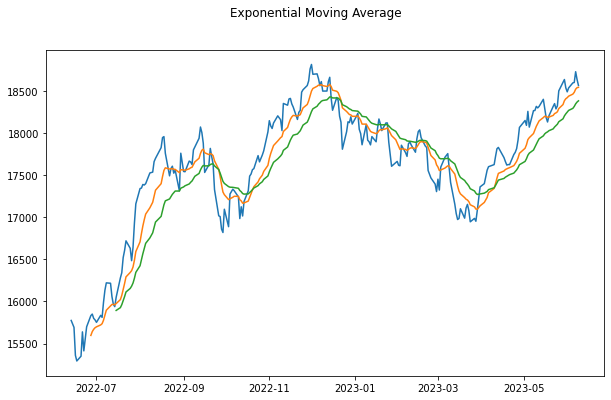

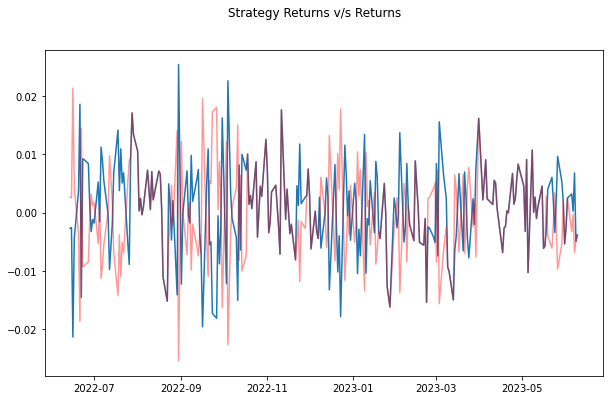

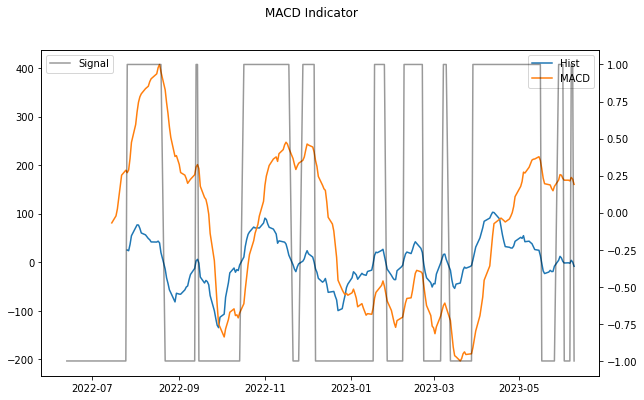

In [10]:
metrics = backtest_plot(df, 12, 26)

print(f"Round-trip trades: {metrics['round_trip_trades']}")
print(f"Total return: {metrics['total_return']:.2f}%")
print(f"Buy & Hold return: {metrics['buy_and_hold_return']:.2f}%")
print(f"Winning trades: {metrics['winning_trades']:.2f}%")
print(f"Max drawdown: {metrics['max_drawdown']:.2f}%")
print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
print(f"Buy and Hold Sharpe Ratio: {metrics['buy_and_hold_sharpe_ratio']:.2f}")
print('\n')

<b>Implementing the bootstrapping protocol to resample the dataset

<b>B1 = 100 samples

In [11]:
n_samples = 100

# Create an empty list to store the results
results = []

# Run the bootstrap protocol
for i in range(n_samples):
    # Resample the data
    resampled_df = df.sample(n=len(df), replace=True).sort_index()
    # Run the backtest on the resampled data
    resampled_results = backtest(resampled_df, 12, 26)
    
    # Add the results to the list
    results.append(resampled_results)

# Calculate the average performance metrics
avg_round_trip_trades = np.mean([r['round_trip_trades'] for r in results])
avg_total_return = np.mean([r['total_return'] for r in results])
avg_buy_and_hold_return = np.mean([r['buy_and_hold_return'] for r in results])
avg_winning_trades = np.mean([r['winning_trades'] for r in results])
avg_max_drawdown = np.mean([r['max_drawdown'] for r in results])
avg_sharpe_ratio = np.mean([r['sharpe_ratio'] for r in results])
avg_buy_and_hold_sharpe_ratio = np.mean([r['buy_and_hold_sharpe_ratio'] for r in results])

# Print the results
print(f"Average round-trip trades: {avg_round_trip_trades:.0f}")
print(f"Average total return: {avg_total_return:.2f}%")
print(f"Average Buy & Hold return: {avg_buy_and_hold_return:.2f}%")
print(f"Average winning trades: {avg_winning_trades:.2f}%")
print(f"Average max drawdown: {avg_max_drawdown:.2f}%")
print(f"Sharpe Ratio: {avg_sharpe_ratio:.2f}")
print(f"Buy and Hold Sharpe Ratio: {avg_buy_and_hold_sharpe_ratio:.2f}")

Average round-trip trades: 18
Average total return: -2.71%
Average Buy & Hold return: 18.16%
Average winning trades: 32.53%
Average max drawdown: -5.84%
Sharpe Ratio: -1.56
Buy and Hold Sharpe Ratio: 1.35


<b>B2 = 250 samples

In [12]:
n_samples = 250

# Create an empty list to store the results
results = []

# Run the bootstrap protocol
for i in range(n_samples):
    # Resample the data
    resampled_df = df.sample(n=len(df), replace=True).sort_index()
    
    # Run the backtest on the resampled data
    resampled_results = backtest(resampled_df, 12, 26)
    
    # Add the results to the list
    results.append(resampled_results)

# Calculate the average performance metrics
avg_round_trip_trades = np.mean([r['round_trip_trades'] for r in results])
avg_total_return = np.mean([r['total_return'] for r in results])
avg_buy_and_hold_return = np.mean([r['buy_and_hold_return'] for r in results])
avg_winning_trades = np.mean([r['winning_trades'] for r in results])
avg_max_drawdown = np.mean([r['max_drawdown'] for r in results])
avg_sharpe_ratio = np.mean([r['sharpe_ratio'] for r in results])
avg_buy_and_hold_sharpe_ratio = np.mean([r['buy_and_hold_sharpe_ratio'] for r in results])

# Print the results
print(f"Average round-trip trades: {avg_round_trip_trades:.0f}")
print(f"Average total return: {avg_total_return:.2f}%")
print(f"Average Buy & Hold return: {avg_buy_and_hold_return:.2f}%")
print(f"Average winning trades: {avg_winning_trades:.2f}%")
print(f"Average max drawdown: {avg_max_drawdown:.2f}%")
print(f"Sharpe Ratio: {avg_sharpe_ratio:.2f}")
print(f"Buy and Hold Sharpe Ratio: {avg_buy_and_hold_sharpe_ratio:.2f}")

Average round-trip trades: 18
Average total return: -2.33%
Average Buy & Hold return: 18.14%
Average winning trades: 32.71%
Average max drawdown: -6.38%
Sharpe Ratio: -1.39
Buy and Hold Sharpe Ratio: 1.36


<b>B3 = 500 samples

In [13]:
n_samples = 500

# Create an empty list to store the results
results = []

# Run the bootstrap protocol
for i in range(n_samples):
    # Resample the data
    resampled_df = df.sample(n=len(df), replace=True).sort_index()
    
    # Run the backtest on the resampled data
    resampled_results = backtest(resampled_df, 12, 26)
    
    # Add the results to the list
    results.append(resampled_results)

# Calculate the average performance metrics
avg_round_trip_trades = np.mean([r['round_trip_trades'] for r in results])
avg_total_return = np.mean([r['total_return'] for r in results])
avg_buy_and_hold_return = np.mean([r['buy_and_hold_return'] for r in results])
avg_winning_trades = np.mean([r['winning_trades'] for r in results])
avg_max_drawdown = np.mean([r['max_drawdown'] for r in results])
avg_sharpe_ratio = np.mean([r['sharpe_ratio'] for r in results])
avg_buy_and_hold_sharpe_ratio = np.mean([r['buy_and_hold_sharpe_ratio'] for r in results])

# Print the results
print(f"Average round-trip trades: {avg_round_trip_trades:.0f}")
print(f"Average total return: {avg_total_return:.2f}%")
print(f"Average Buy & Hold return: {avg_buy_and_hold_return:.2f}%")
print(f"Average winning trades: {avg_winning_trades:.2f}%")
print(f"Average max drawdown: {avg_max_drawdown:.2f}%")
print(f"Sharpe Ratio: {avg_sharpe_ratio:.2f}")
print(f"Buy and Hold Sharpe Ratio: {avg_buy_and_hold_sharpe_ratio:.2f}")

Average round-trip trades: 19
Average total return: -2.95%
Average Buy & Hold return: 18.17%
Average winning trades: 32.38%
Average max drawdown: -5.88%
Sharpe Ratio: -1.72
Buy and Hold Sharpe Ratio: 1.36


<b>B4 = 750 samples

In [14]:
n_samples = 750

# Create an empty list to store the results
results = []

# Run the bootstrap protocol
for i in range(n_samples):
    # Resample the data
    resampled_df = df.sample(n=len(df), replace=True).sort_index()
    
    # Run the backtest on the resampled data
    resampled_results = backtest(resampled_df, 12, 26)
    
    # Add the results to the list
    results.append(resampled_results)

# Calculate the average performance metrics
avg_round_trip_trades = np.mean([r['round_trip_trades'] for r in results])
avg_total_return = np.mean([r['total_return'] for r in results])
avg_buy_and_hold_return = np.mean([r['buy_and_hold_return'] for r in results])
avg_winning_trades = np.mean([r['winning_trades'] for r in results])
avg_max_drawdown = np.mean([r['max_drawdown'] for r in results])
avg_sharpe_ratio = np.mean([r['sharpe_ratio'] for r in results])
avg_buy_and_hold_sharpe_ratio = np.mean([r['buy_and_hold_sharpe_ratio'] for r in results])

# Print the results
print(f"Average round-trip trades: {avg_round_trip_trades:.0f}")
print(f"Average total return: {avg_total_return:.2f}%")
print(f"Average Buy & Hold return: {avg_buy_and_hold_return:.2f}%")
print(f"Average winning trades: {avg_winning_trades:.2f}%")
print(f"Average max drawdown: {avg_max_drawdown:.2f}%")
print(f"Sharpe Ratio: {avg_sharpe_ratio:.2f}")
print(f"Buy and Hold Sharpe Ratio: {avg_buy_and_hold_sharpe_ratio:.2f}")

Average round-trip trades: 18
Average total return: -2.70%
Average Buy & Hold return: 18.12%
Average winning trades: 32.55%
Average max drawdown: -6.01%
Sharpe Ratio: -1.55
Buy and Hold Sharpe Ratio: 1.35


<b> P/L Distribution for the Total Returns

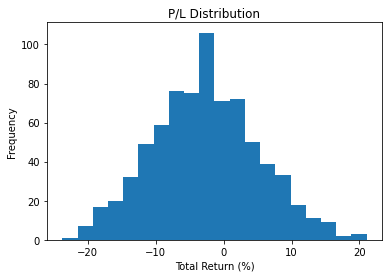

In [15]:
total_returns = [r['total_return'] for r in results]
plt.hist(total_returns, bins=20)
plt.xlabel('Total Return (%)')
plt.ylabel('Frequency')
plt.title('P/L Distribution')
plt.show()

<b> Check if mean total returns differs significantly from zero

In [16]:
from scipy.stats import ttest_1samp

tstat, pvalue = ttest_1samp(total_returns, 0)

print("T-Statistics: ", tstat)
print("P-Value: ", pvalue)
print("\n")

if pvalue < 0.05:
    print('The mean total return differs significantly from zero (p-value < 0.05).')
else:
    print('The mean total return does not differ significantly from zero (p-value >= 0.05).')

T-Statistics:  -9.468049051285321
P-Value:  3.6224303442458575e-20


The mean total return differs significantly from zero (p-value < 0.05).
